In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(10,10)
    self.gen = nn.Sequential(
          nn.Linear(100+10,256),
          nn.LeakyReLU(0.2),
          nn.Linear(256,512),
          nn.LeakyReLU(0.2),
          nn.Linear(512,1024),
          nn.LeakyReLU(0.2),
          nn.Linear(1024,28*28),
          nn.Tanh(),
      )
  def forward(self,x,label):
    x = torch.cat([x,self.embed(label)],1)
    x = self.gen(x)
    return x.view(-1,1,28,28)

In [3]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(10,10)
    self.dis = nn.Sequential(
        nn.Linear(28*28+10,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256,1),
        nn.Sigmoid()      
    )
  def forward(self,x,label):
    x = torch.cat([x,self.embed(label)],1)
    return self.dis(x)

In [4]:
dataset = torchvision.datasets.MNIST(root='/content/',download=True,transform=transforms.Compose([transforms.ToTensor()
                                                                                                  ,transforms.Normalize((.5,), (.5,))
                                                                                                  ]))
dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=100,shuffle=True)


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
epochs = 50
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 100

disc = Discriminator().to(device)
gen = Generator().to(device)

criterion = nn.BCELoss()
opt_disc = torch.optim.Adam(params=disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(params=gen.parameters(),lr=lr)

In [6]:
for epoch in range(0,epochs):
  for batch_index , (real_images,real_labels) in enumerate(dataloader):
    real_images = real_images.to(device)
    real_images = real_images.view(-1,28*28)
    batch_size = real_images.shape[0]
    real_label = real_labels.to(device)

    # Training the Discriminator
    noise = torch.randn(batch_size,100).to(device)
    fake_images = gen(noise,real_label)
    fake_images = fake_images.view(-1,28*28)

    disc_real_images = disc(real_images,real_label).view(batch_size)    
    disc_fake_images = disc(fake_images,real_label).view(batch_size)

    loss_real_images = criterion(disc_real_images,torch.ones_like(disc_real_images))
    loss_fake_images = criterion(disc_fake_images,torch.zeros_like(disc_fake_images))
    lossD = loss_real_images + loss_fake_images
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #Training the Generator
    result = disc(fake_images,real_label)
    lossG = criterion(result,torch.ones_like(result))
    gen.zero_grad()
    lossG.backward(retain_graph=True)
    opt_gen.step()
    if batch_index % 100 == 0:
      print(f"Epoch {epoch}/{epochs} Batch {batch_index}/{len(dataloader)} Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

Epoch 0/50 Batch 0/600 Loss D: 1.3823, loss G: 0.6664
Epoch 0/50 Batch 100/600 Loss D: 0.4225, loss G: 1.7960
Epoch 0/50 Batch 200/600 Loss D: 0.4332, loss G: 2.3253
Epoch 0/50 Batch 300/600 Loss D: 0.3118, loss G: 3.1122
Epoch 0/50 Batch 400/600 Loss D: 0.4154, loss G: 3.2338
Epoch 0/50 Batch 500/600 Loss D: 1.5149, loss G: 1.6365
Epoch 1/50 Batch 0/600 Loss D: 1.1037, loss G: 2.3640
Epoch 1/50 Batch 100/600 Loss D: 0.4963, loss G: 2.4166
Epoch 1/50 Batch 200/600 Loss D: 1.5697, loss G: 0.5136
Epoch 1/50 Batch 300/600 Loss D: 1.2054, loss G: 0.9368
Epoch 1/50 Batch 400/600 Loss D: 0.6179, loss G: 2.0382
Epoch 1/50 Batch 500/600 Loss D: 0.6834, loss G: 1.7558
Epoch 2/50 Batch 0/600 Loss D: 0.5922, loss G: 1.8450
Epoch 2/50 Batch 100/600 Loss D: 0.3419, loss G: 2.5602
Epoch 2/50 Batch 200/600 Loss D: 0.3364, loss G: 3.2466
Epoch 2/50 Batch 300/600 Loss D: 0.1796, loss G: 3.3403
Epoch 2/50 Batch 400/600 Loss D: 0.2180, loss G: 3.0479
Epoch 2/50 Batch 500/600 Loss D: 0.7867, loss G: 2.369

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


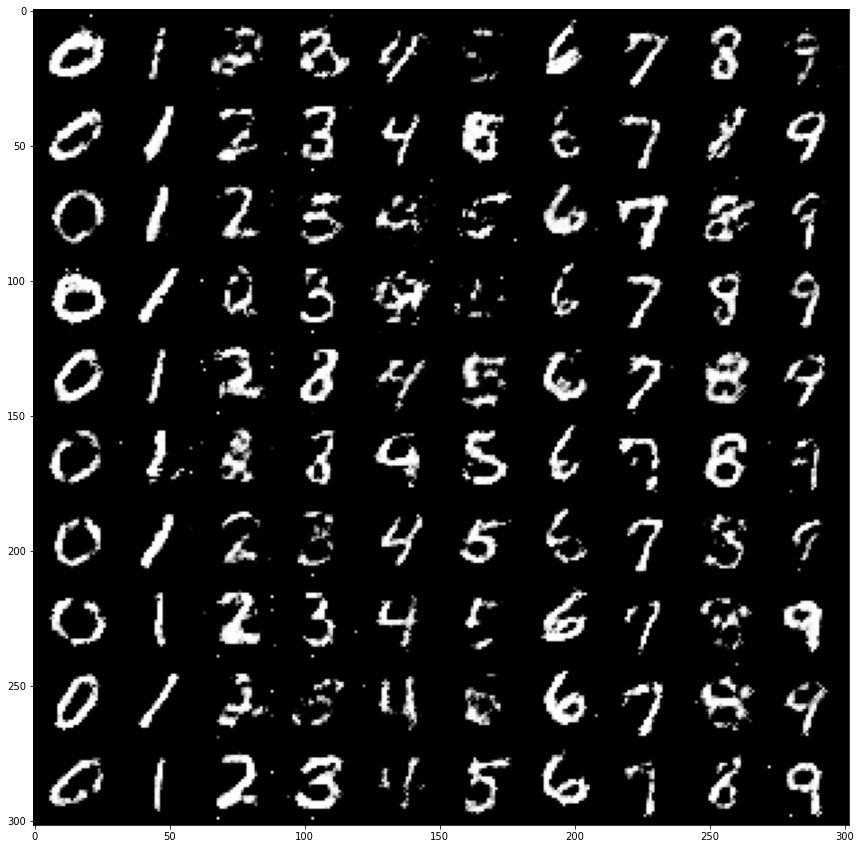

In [7]:
from torchvision.utils import make_grid

noise = torch.randn(100,100)
label = torch.LongTensor([i for _ in range(10) for i in range(10)])

generated_images = gen(noise.to(device),label.to(device))
generated_images = generated_images.cpu()

grid = make_grid(generated_images, nrow=10, normalize=False).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)